# Decision Trees
---

### Objectives:

- Develop a classification model using Decision Tree Algorithm

- Apply Decision Tree classification on a real world dataset.

### Installs:

In [0]:
%%capture
%pip install numpy==2.4.0
%pip install pandas==2.3.3
%pip install scikit-learn==1.8.0
%pip install matplotlib==3.10.8
%pip install seaborn==0.13.0

In [0]:
# Command to restart the kernel and update the installed libraries
%restart_python

### Imports:

In [0]:
# Data Analize and Visualization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import seaborn as sns

# Data Modeling / Model Linear / Metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, ConfusionMatrixDisplay

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [0]:
df = pd.read_csv('./data/drug200.csv')

### Verify successful load with some randomly selected records


In [0]:
df.sample(9)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
130,70,F,NORMAL,HIGH,20.489,drugY
171,45,M,LOW,NORMAL,10.017,drugX
57,40,M,HIGH,HIGH,27.826,drugY
194,46,F,HIGH,HIGH,34.686,drugY
174,42,M,HIGH,NORMAL,12.766,drugA
164,16,M,HIGH,NORMAL,19.007,drugY
110,50,M,HIGH,HIGH,7.490,drugA
67,17,M,NORMAL,NORMAL,10.832,drugX
83,38,F,HIGH,NORMAL,11.326,drugA


### Understand the data
---

These data are about a group of patients, all with the same disease. During treatment, each patient responded to one of five medications: Medication A, Medication B, Medication C, Medication X, and Medication Y.

The goal is to build a model to discover which medication would be most suitable for a future patient with the same disease. The characteristics of this dataset are the patients' age, sex, blood pressure, and cholesterol, and the objective is to determine which medication each patient responded to.


* **Age** *Continuous* -Patient's age

* **Sex** *Categorical* -Patient's gender (F = Female, M = Male)

* **BP** *Categorical* -Blood Pressure levels (LOW, NORMAL, HIGH)

* **Cholesterol** *Categorical* -Serum Cholesterol levels (NORMAL, HIGH)

* **Na_to_K** *Continuous* -Sodium to Potassium ratio in blood

* **Drug** *Categorical* -Type of drug suitable for the patient (Target Variable)

### Explore the data
First, consider a statistical summary of the data.

In [0]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [0]:
df.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

Visualize the distribution of the target variable to understand the class balance.

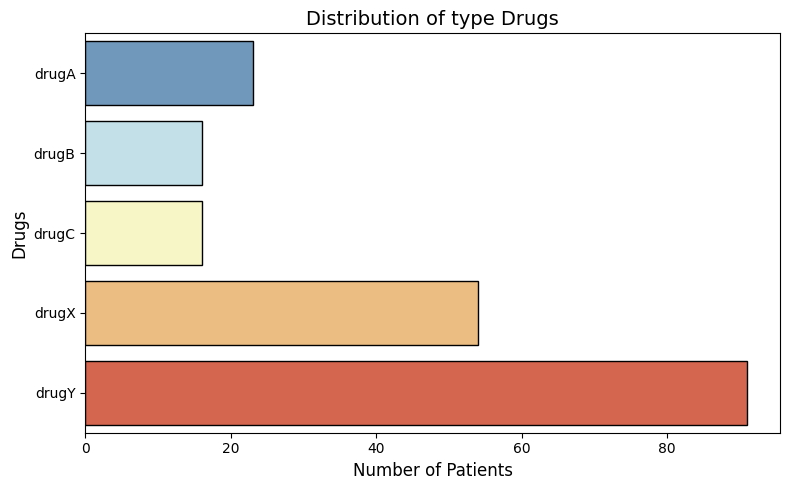

In [0]:
level_order = [
    'drugA', 
    'drugB', 
    'drugC', 
    'drugX', 
    'drugY', 
]

# Figure
plt.figure(figsize = (8, 5))

# Count Plot
ax = sns.countplot(
    y = 'Drug',
    data = df,
    order = level_order,
    edgecolor = 'black',
    palette = 'RdYlBu_r',
)

plt.title('Distribution of type Drugs', fontsize = 14)
plt.xlabel('Number of Patients', fontsize = 12)
plt.ylabel('Drugs', fontsize = 12)

plt.tight_layout()
plt.show()

In the distribution of classes, it is clear that Drug X and Drug Y have significantly more records compared to the other three.

### Encoding the columns for correlation analysis between variables.

In [0]:
df_encoded = df.copy()

# Variable Sex
var_sex_map = {'M': 0, 'F': 1}
df_encoded['Sex'] = df_encoded['Sex'].map(var_sex_map)

# Variable BP
var_bp_map = {'LOW': 0, 'NORMAL': 1, 'HIGH': 2}
df_encoded['BP'] = df_encoded['BP'].map(var_bp_map)

# Variable Cholesterol
var_cholesterol_map = {'NORMAL': 0, 'HIGH': 1}
df_encoded['Cholesterol'] = df_encoded['Cholesterol'].map(var_cholesterol_map)

# Target Variable >>> Drug
var_drug_map = {'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4}
df_encoded['Drug'] = df_encoded['Drug'].map(var_drug_map)

df_encoded.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,2,1,25.355,4
1,47,0,0,1,13.093,2
2,47,0,0,1,10.114,2
3,28,1,1,1,7.798,3
4,61,1,0,1,18.043,4
5,22,1,1,1,8.607,3
6,49,1,1,1,16.275,4
7,41,0,0,1,11.037,2
8,60,0,1,1,15.171,4
9,43,0,0,0,19.368,4


In [0]:
df_encoded.corr()['Drug'].abs().sort_values(ascending = False)

Drug           1.000000
Na_to_K        0.589120
BP             0.328665
Sex            0.098573
Cholesterol    0.055629
Age            0.004828
Name: Drug, dtype: float64

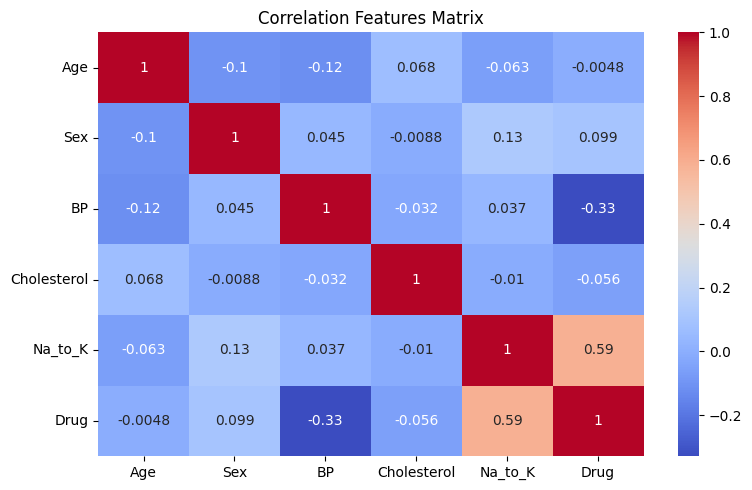

In [0]:
plt.rc('font', size = 10)
fig, ax = plt.subplots(figsize = (8, 5))
sns.heatmap(df_encoded.corr(), annot = True, cmap = 'coolwarm', ax = ax)
ax.set_title('Correlation Features Matrix')
plt.tight_layout()
plt.show()

### Preprocessing the data

Extract the input features and label

In [0]:
X = df_encoded.drop(columns = ['Drug']).copy()
y = df_encoded['Drug'].copy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 33)
print(f'The shape X_train: {X_train.shape}')
print(f'The shape y_train: {y_train.shape}')
print(f'The shape X_test: {X_test.shape}')
print(f'The shape y_test: {y_test.shape}')

The shape X_train: (140, 5)
The shape y_train: (140,)
The shape X_test: (60, 5)
The shape y_test: (60,)


### Build a Decion Tree Classifier Model

In [0]:
drug_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)
drug_tree.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'entropy'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [0]:
# Predict the target variable in the test data
y_pred = drug_tree.predict(X_test)
# Collecting the probabilities of the model classifications
y_prob = drug_tree.predict_proba(X_test)

### Model Evaluation

In [0]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_prob, multi_class = 'ovr'):.2f}')
print(f'Root men squared error: {log_loss(y_test, y_prob):.2f}')

Accuracy: 0.98
AUC-ROC: 0.99
Root men squared error: 0.60



Visualize the tree
To understand the classification criteria derived by the Decision Tree, we may generate the tree plot.

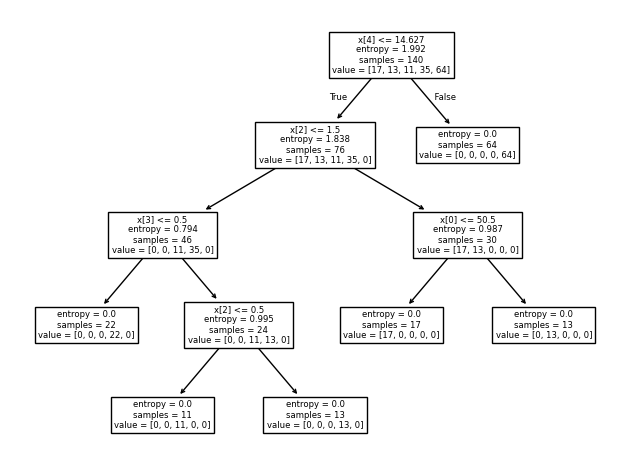

In [0]:
plot_tree(drug_tree)
plt.tight_layout()
plt.show()

From this tree, we can derive the criteria developed by the model to identify the class of each training sample. We can interpret them by tracing the criteria defined by tracing down from the root to the tree's leaf nodes.

For instance, the decision criterion for Drug Y is  Na_to_K>14.627 .

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      0.95      0.97        19
           4       0.96      1.00      0.98        27

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60



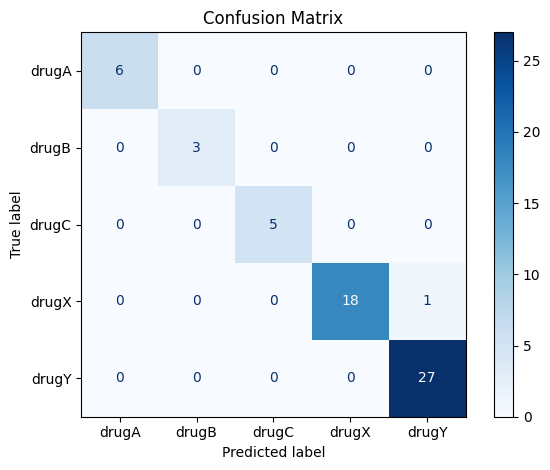

In [0]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels = ['drugA', 'drugB', 'drugC', 'drugX', 'drugY'], 
    cmap = 'Blues', 
    values_format = 'd'
)

plt.grid(False) 
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### Conclusion
---

- The developed **Decision Tree** model (using entropy criteria and a maximum depth of 4) demonstrates statistical robustness and predictive capacity. With a **98% Accuracy** and an impressive **Area Under the Curve (AUC-ROC) of 0.99**, the classifier exhibits near-perfect discriminatory competence.

- Performance analysis by class reveals ideal separation for most categories:

  - **Classes 0, 1, and 2** achieved **perfect scores (1.00)** in Accuracy, Recall, and F1-Score. This indicates that the decision rules generated by the tree for these specific drug types are unambiguous and highly distinct based on the patient's clinical characteristics (BP, Cholesterol, Na/K).

  - A small variability was observed only in **classes 3 and 4**, where Recall (0.95) and Precision (0.96) showed marginal errors. This suggests a small overlap in the feature space for these specific segments, probably resolved by small adjustments in the tree depth or hyperparameter optimization.

- The use of **Entropy** as a division criterion proved effective in reducing impurity at each node, allowing the model to achieve this high level of precision with a relatively shallow tree (Depth = 4), which favors interpretability and avoids overfitting.

- The **RMSE of 0.60** suggests that, even when errors occur, the estimated deviations are within an acceptable range relative to the actual classes.%md
